# Basic Usage - Finding Molecular Formulae

`find_mfs` is a Python implementation of the Böcker-Lipták algorithm for finding molecular formulae candidates which fit some given mass (+/- an error window). `find_mfs` also implements other methods for filtering the candidate lists:
- Checking whether a molecular formulae satisfies the octet rule
- Filtering by ring/double bond equivalents (RDBE's)
- Filtering by predicted isotope envelopes, generated using  using Łącki and Startek's algorithm as implemented in `IsoSpecPy`

---

**If you use this package, make sure to cite:**
- [Böcker & Lipták, 2007](https://link.springer.com/article/10.1007/s00453-007-0162-8) - this package uses their algorithm for formula finding...
    - ...as implemented in SIRIUS: [Böcker et. al., 2008](https://academic.oup.com/bioinformatics/article/25/2/218/218950)
- [Łącki, Valkenborg & Startek 2020](https://pubs.acs.org/doi/10.1021/acs.analchem.0c00959) - this package uses IsoSpecPy to quickly simulate isotope envelopes
- [Gohlke, 2025](https://zenodo.org/records/17059777) - this package uses `molmass`, which provides very convenient methods for handling chemical formulae

---

## Finding Molecular Formulae

A `FormulaFinder` instance must be initialized like so:

In [1]:
from find_mfs import FormulaFinder

# Initializing a FormulaFinder uses CHNOPS elements by default
finder = FormulaFinder()

results = finder.find_formulae(
    mass=613.2391,         # Novobiocin [M+H]+ ion; C31H37N2O11+
    charge=1,              # Charge should be specified - electron mass matters
    adduct="H",            # If known, adduct should be specified
    error_ppm=5.0,         # Can also specify error_da instead
                           # --- FORMULA FILTERS ----
    check_octet=True,      # Candidates must obey the octet rule
    filter_rdbe=(0, 20),   # Candidates must have 0 to 20 ring/double-bond equivalents
    max_counts={
        'P': 0,            # Candidates must not have any phosophorous atoms
        'S': 2,            # Candidates can have up to two sulfur atoms
    },
)

print(results)

FormulaSearchResults(query_mass=613.2391, n_results=39, adduct=[M+H]+)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
C6H24N30O4S                        -0.12      -0.000073      10.0
C31H36N2O11                         0.14       0.000086      15.0
C14H28N24OS2                        0.18       0.000110      13.0
C16H40N10O11S2                      0.20       0.000121       2.0
C29H32N12S2                        -0.64      -0.000392      20.0
... and 34 more


In [2]:
finder.find_formulae(
    mass=635.22113,        # Novobiocin [M+Na]+ ion; C31H36N2O11Na+
    charge=1,              # Charge should be specified - electron mass matters
    error_ppm=5.0,         # Can also specify error_da instead
    adduct='Na',
)

FormulaSearchResults(query_mass=635.2211, n_results=2425, adduct=[M+Na]+)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
C31H36N2O11                         0.00       0.000001      15.0
C2H64N10O4S10                       0.00       0.000003     -24.0
C30H30N9O6                         -0.01      -0.000005      20.5
H50N14O13P2S3                       0.01       0.000006     -14.0
C4H66N3O11P8S                      -0.01      -0.000007     -14.5
... and 2420 more

In [3]:
finder.find_formulae(
    mass=647.20131,        # Novobiocin [M+Cl]- ion; C31H36N2O11Cl-
    charge=-1,             # Charge should be specified - electron mass matters
    error_ppm=5.0,         # Can also specify error_da instead
    adduct='Cl',
)

FormulaSearchResults(query_mass=647.2013, n_results=2475, adduct=[M+Cl]-)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
C31H36N2O11                         0.00       0.000001      15.0
C2H64N10O4S10                       0.01       0.000004     -24.0
C30H30N9O6                         -0.01      -0.000004      20.5
H50N14O13P2S3                       0.01       0.000007     -14.0
C4H66N3O11P8S                      -0.01      -0.000007     -14.5
... and 2470 more

In [4]:
# Alternatively, min_ and max_counts can be given as formulae. This is useful for assigning ion fragment formulae:
finder.find_formulae(
    mass=189.09133,           # Fragment of Novobiocin [M+H]+ ion
    charge=1,
    error_ppm=5.0,
    max_counts='C31H37N2O11', # The MF candidates can't have any atoms that aren't in the parent
    check_octet=True,
    filter_rdbe=(0, 20),
)

FormulaSearchResults(query_mass=189.0913, n_results=1)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C12H13O2]+                        -1.71      -0.000324       6.5

## Formula Search Results

`find_formulae()` returns a `FormulaSearchResults` object, which implements some useful methods:

In [5]:
# Results can be further reduced by chaining filters, like so:
constrained_results = (
    results
    .filter_by_error(max_ppm=1.0)  # Tighter error window (also accepts max_da)
    .filter_by_rdbe(5, 20)         # Adjusting RBDE range
    .top(5)                        # Keep the top 5 results
)

print(constrained_results)

FormulaSearchResults(query_mass=613.2391, n_results=5, adduct=[M+H]+)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
C6H24N30O4S                        -0.12      -0.000073      10.0
C31H36N2O11                         0.14       0.000086      15.0
C14H28N24OS2                        0.18       0.000110      13.0
C29H32N12S2                        -0.64      -0.000392      20.0
C23H40N4O13S                       -0.92      -0.000565       6.0


In [6]:
# If Pandas is installed, results can be converted into a DataFrame
df = results.to_dataframe()
df.head()

,formula,error_ppm,error_da,rdbe,mass
0,C6H24N30O4S,-0.119021,-0.000073,10.0,612.231751
1,C31H36N2O11,0.140951,0.000086,15.0,612.231910
2,C14H28N24OS2,0.180076,0.000110,13.0,612.231934
3,C16H40N10O11S2,0.197231,0.000121,2.0,612.231944
4,C29H32N12S2,-0.639415,-0.000392,20.0,612.231431


## Molecular Formulae Candidates
`FormulaSearchResults` is a container for `FormulaCandidate` objects, which have the following attributes:

In [7]:
mf_candidate = results[0]

for tag, attribute in (
    ("Formula: ", mf_candidate.formula),
    ("Error (ppm): ", round(mf_candidate.error_ppm, 2)),  
    ("Error (Da): ", round(mf_candidate.error_da, 5)),
    ("RDBE: ", mf_candidate.rdbe),
):
    print(f"{tag:<20}{attribute}")

Formula:            C6H24N30O4S
Error (ppm):        -0.12
Error (Da):         -7e-05
RDBE:               10.0


In [8]:
# `find_mfs` uses the `molmass` library, which has some useful features:
formula = mf_candidate.formula

# Here are some examples. Be sure to check out the molmass documentation
for tag, attribute in (
    ("Empirical formula: ", formula.empirical),
    ("Charge: ", formula.charge),
    ("Number of atoms: ", formula.atoms),
    ("Nominal mass: ", formula.nominal_mass),
):
    print(f"{tag:<20}{attribute}")

print(
    f"\n As dataframe:"
)
formula.composition().dataframe()

Empirical formula:  C6H24N30O4S
Charge:             0
Number of atoms:    65
Nominal mass:       612

 As dataframe:


,Count,Relative mass,Fraction
Element,,,
H,24,24.190584,0.039494
C,6,72.064440,0.117653
N,30,420.201090,0.686022
O,4,63.997620,0.104483
S,1,32.064800,0.052349


## Filtering Using Isotope Patterns

Even with <1.0 ppm mass accuracy, it's usually not possible to assign molecular formulae based on mass alone. An easy way to get around this is to filter down the candidate list by comparing predicted/observed isotope envelopes (see: [Kind & Fiehn 2006](https://link.springer.com/article/10.1186/1471-2105-7-234)).

`find_mfs` implements such filtering, using [IsoSpecPy](http://matteolacki.github.io/IsoSpec/) to simulate isotope envelopes.

**If you use this functionality, make sure to cite the IsoSpec2 paper!** ([Łącki, Valkenborg & Startek 2020](https://pubs.acs.org/doi/10.1021/acs.analchem.0c00959))

---

In the following example, a single isotope envelope observation is used:

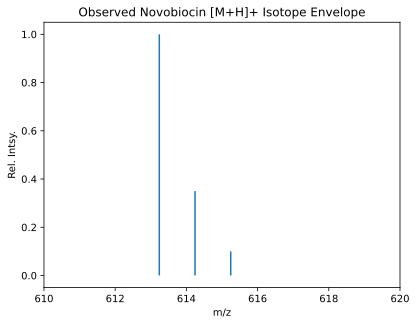

In [9]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import numpy as np

# Isotope envelope for novobiocin's [M+H]+ ion (C31H37N2O11+)
observed_envelope = np.array(
    [  #  m/z    , relative intsy.
        [613.2397,    1.00],
        [614.2429,    0.35],
        [615.2456,    0.10],
    ]
)

plt.xlabel('m/z')
plt.ylabel('Rel. Intsy.')
plt.title(
    'Observed Novobiocin [M+H]+ Isotope Envelope'
)
plt.xlim(610, 620)
plot = plt.stem(
    observed_envelope[:, 0],
    observed_envelope[:, 1],
    markerfmt=' ',
    basefmt=' ',
)

In [10]:
# To use isotope matching, parameters must be defined like so:
from find_mfs import SingleEnvelopeMatch

iso_config = SingleEnvelopeMatch(
    envelope=observed_envelope,     # np.ndarray with an m/z column and an intensity column
    mz_tolerance_da=0.005,          # Tolerance for aligning isotope signals. Should be very generous. Can also use mz_tolerance_ppm
    minimum_rmse=0.05,              # Default is 0.05, i.e. instrument reproduces isotope envelope w/ 5% fidelity
)

iso_matched_results = finder.find_formulae(
    mass=613.2391,         # Novobiocin [M+H]+ ion; C31H37N2O11+
    charge=1,              # Charge should be specified - electron mass matters
    adduct="H",
    error_ppm=3.0,         # Can also specify error_da instead
                           # --- FORMULA FILTERS ----
    check_octet=True,      # Candidates must obey the octet rule
    filter_rdbe=(0, 20),   # Candidates must have 0 to 20 ring/double-bond equivalents
    max_counts={
        'P': 0,            # Candidates must not have any phosophorous atoms
        'S': 2,            # Candidates can have up to two sulfur atoms
    },
    isotope_match=iso_config,
)

print(iso_matched_results)

FormulaSearchResults(query_mass=613.2391, n_results=5, adduct=[M+H]+)

Formula                   Error (ppm)     Error (Da)      RDBE       Iso. Matches   Iso. RMSE 
------------------------------------------------------------------------------------------------
C31H36N2O11                         0.14       0.000086      15.0           3/3    0.0121
C23H40N4O13S                       -0.92      -0.000565       6.0           3/3    0.0478
C24H36N8O9S                         1.26       0.000772      11.0           3/3    0.0311
C32H32N6O7                          2.32       0.001424      20.0           3/3    0.0230
C25H32N12O5S                        3.44       0.002110      16.0           3/3    0.0146


In [11]:
# Finally, if the results contain isotope envelope matches, they can be filtered like so:
iso_matched_results.filter_by_isotope_quality(
    min_match_fraction=1.00,  # Only show MF candidates that matched ALL of the observed isotope envelope
    max_match_rmse=0.02,      # Only show MF candidates with isotope envelope intensity RMSE smaller than 2%
)

FormulaSearchResults(query_mass=613.2391, n_results=2, adduct=[M+H]+)

Formula                   Error (ppm)     Error (Da)      RDBE       Iso. Matches   Iso. RMSE 
------------------------------------------------------------------------------------------------
C31H36N2O11                         0.14       0.000086      15.0           3/3    0.0121
C25H32N12O5S                        3.44       0.002110      16.0           3/3    0.0146

## A Note About Defining Element Sets

The Böcker-Lipták algorithm involves first constructing an *extended residue table* (ERT) using the elements to be considered during decomposition. This computation is done upfront, and dramatically speeds up formula finding later. However, constructing the residue table can take a few seconds.

For common element sets (i.e. 'CHNOPS' and 'CHNOPSFBrClI'), a pre-calculated ERT is retrieved, to save time. If the user is specifying a different element set, please note that initializing `FormulaFinder(...)` can take a few seconds - so make sure you don't put that inside a loop.

**More importantly, if the user wishes to include a *subset* of CHNOPS or CHNOPS + Halogens, it's more efficient to just specify element limits rather than constructing an entire new element set, like so:**

In [12]:
halogen_finder = FormulaFinder("CHNOPSBrClIF")   # Fast, loads pre-calculated ERT

halogen_finder.find_formulae(
    mass = 289.0950,  # Chlorotetaine [M+H]+ ion; C12H18ClN2O4+
    error_ppm=5.0,
    charge=1,
    min_counts = {
        'Cl': 1,
    },
    max_counts = {    # Results only contain Cl, and not other halogens
        'F': 0,
        'Br': 0,
        'I': 0,
    },
    check_octet=True,
)

FormulaSearchResults(query_mass=289.0950, n_results=29)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C12H18ClN2O4]+                    -0.13      -0.000039       4.5
[CH25Cl4N8]+                        0.28       0.000080      -8.5
[H25Cl3N8OP]+                      -0.33      -0.000096      -7.5
[C4H32ClO3P2S2]+                    0.40       0.000115      -8.5
[C5H26ClN4OS3]+                     0.62       0.000179      -5.5
... and 24 more

In [13]:
# Example using custom element set:

custom_finder = FormulaFinder(
    elements=['C', 'H', 'N', 'O', 'P', 'S', 'Cl', 'V']
)   

custom_finder.find_formulae(
    mass = 289.0950,
    error_ppm=5.0,
    charge=1,
    min_counts = {    # Constraints can be defined either as dicts or strings
        'Cl': 1,      # These constraints force results to contain 1 Cl and 1 V
        'V': 1,
    },
    max_counts = 'C*H*N*O*P0S1V1Cl1',
)

FormulaSearchResults(query_mass=289.0950, n_results=2)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C4H23ClN6O3V]+                     1.47       0.000425       N/A
[C12H27ClSV]+                       2.10       0.000608       N/A

In [14]:
finder.find_formulae(
    mass=613.2391,            # Parent ion m/z (i.e. novobiocin)
    charge=1,              
    error_ppm=2.0,
    min_counts='C12H13O2',     # formula of some fragment ion we want to constrain by
    max_counts='C*H*N*O*S3P0', # should still specify max element count constraints
    check_octet=True,
    filter_rdbe=(0, 20),
)

FormulaSearchResults(query_mass=613.2391, n_results=11)

Formula                   Error (ppm)     Error (Da)      RDBE      
----------------------------------------------------------------------
[C31H37N2O11]+                      0.14       0.000086      14.5
[C16H41N10O11S2]+                   0.20       0.000121       1.5
[C24H45N4O8S3]+                     0.50       0.000304       4.5
[C23H41N4O13S]+                    -0.92      -0.000565       5.5
[C21H29N18O3S]+                    -0.94      -0.000576      16.5
... and 6 more